<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd_(further_work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd%20(further%20work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab + Imports + Paths

In [12]:
import pandas as pd, numpy as np, ast, json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import torch, torch.nn as nn
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaForTokenClassification,
    Trainer, TrainingArguments
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings; warnings.filterwarnings('ignore')
from transformers import logging; logging.set_verbosity_error()
import matplotlib.pyplot as plt; import seaborn as sns
from google.colab import drive; drive.mount('/content/drive')
import os; os.environ['TOKENIZER_PARALLELISM'] = 'false'

PROJECT_ROOT = '/content/drive/MyDrive/Metaphor-Classification-NLP'
DATA_PROC = f'{PROJECT_ROOT}/data/processed'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [23]:
EXPERIMENT = "EN_BALANCED_POS"  # "EN", "RU_ZERO", "RU_HEAD", "RU_FULL", "EN_BALANCED_POS"
SEED = 123
MAX_LEN = 32
BATCH_SIZE = 16

# Final weights from your runs
EN_CLASS_WEIGHTS = torch.tensor([0.232, 1.384])
RU_CLASS_WEIGHTS = torch.tensor([0.53, 10.07])  # 95/5 RU imbalance

tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base', add_prefix_space=True)

## Utilities: Dataset + Trainer

In [3]:
from torch.utils.data import Dataset

class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Encodings for Trainer
        self.encodings = {
            'input_ids': [],
            'attention_mask': [],
            'labels': []
        }

        # Separate lists to use later for evaluation
        self.word_ids_list = []
        self.simple_pos_list = []

        # POS mapping (simplified)
        self.simple_pos_mapping = {'nan': 'na', 'verb': 'verb', 'noun': 'noun', 'adv': 'adv',
                                   'adj': 'adj', 'SPECIAL': 'SPECIAL',
                                   'SUBWORD': 'SUBWORD', 'UNKNOWN_POS': 'UNKNOWN_POS', 'PAD': 'PAD'}

        for idx, row in self.df.iterrows():
            words = [str(w) for w in row["words"]]
            labels = [int(l) for l in row["labels"]]
            simple_pos = [str(p) for p in row["pos"]] # These are the actual POS tags

            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )

            word_ids = encoding.word_ids(batch_index=0)
            aligned_labels = []
            aligned_pos = []

            prev_word_id = None
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels.append(-100)
                    aligned_pos.append("SPECIAL")
                elif word_id != prev_word_id:
                    aligned_labels.append(labels[word_id])
                    aligned_pos.append(simple_pos[word_id])
                    prev_word_id = word_id
                else:
                    aligned_labels.append(-100)
                    aligned_pos.append("SUBWORD")

            # Convert to tensors
            self.encodings['input_ids'].append(encoding['input_ids'].squeeze(0))
            self.encodings['attention_mask'].append(encoding['attention_mask'].squeeze(0))
            self.encodings['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

            # Save for evaluation
            self.word_ids_list.append(word_ids)
            self.simple_pos_list.append(aligned_pos)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        # Support both single index and batch (list/ndarray) index
        if isinstance(idx, (int, np.integer)):
            return {key: self.encodings[key][idx] for key in self.encodings}
        # If idx is a list, tuple, or np.ndarray, return a batch
        if isinstance(idx, (list, tuple, np.ndarray)):
            return {key: [self.encodings[key][i] for i in idx] for key in self.encodings}
        raise TypeError(f"Invalid index type: {type(idx)}")

In [4]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #Enhanced compute_loss with weighted cross entropy for class imbalance
        expected_keys = ["input_ids", "attention_mask", "labels"]
        model_inputs = {key: inputs[key] for key in expected_keys if key in inputs}

        labels = model_inputs.get("labels") # Get labels separately as they are used in loss calculation

        # Pass expected inputs to the model
        outputs = model(**model_inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [44]:
# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    # Access the logits from the predictions tuple (predictions[0])
    predictions = predictions[0].argmax(axis=-1)

    # Remove ignored index (-100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }

## 3. POS Balancing

In [6]:
def sample_balanced_pos(df, pos_categories_to_balance, random_state=42):
    """
    Samples sentences to achieve a roughly equal number of metaphorical tokens
    for the specified POS categories, based on the count of the most underrepresented category.
    """
    # First, count the occurrences of metaphorical tokens for each specified POS category
    pos_counts_in_metaphors = {pos: 0 for pos in pos_categories_to_balance}
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        for pos in metaphorical_pos:
            if pos in pos_counts_in_metaphors:
                pos_counts_in_metaphors[pos] += 1

    # Determine the count of the most underrepresented POS category
    min_pos_count = min(pos_counts_in_metaphors.values())
    print(f"Target samples per balanced POS category: {min_pos_count}")

    sampled_indices = []
    current_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

    # Iterate through the DataFrame again to sample
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        # Check if adding this sentence helps reach the target for any of the specified POS
        add_sentence = False
        for pos in metaphorical_pos:
            if pos in current_pos_counts and current_pos_counts[pos] < min_pos_count:
                add_sentence = True
                break

        if add_sentence:
            sampled_indices.append(index)
            # Update counts for the specified POS tags in the sentence
            for pos in metaphorical_pos:
                if pos in current_pos_counts:
                    current_pos_counts[pos] += 1

    # Create a new DataFrame with the sampled sentences
    sampled_df = df.loc[sampled_indices].reset_index(drop=True)
    return sampled_df


POS_CATEGORIES_TO_BALANCE = ['noun', 'verb', 'adj', 'adv', 'nan']

## Utilities: Helpers


In [46]:
def make_doc_splits(df, test_size=0.3, val_size=0.5, seed=SEED):
    doc_ids = df["document_name"].unique()
    train_ids, temp_ids = train_test_split(doc_ids, test_size=test_size, random_state=seed)
    val_ids, test_ids = train_test_split(temp_ids, test_size=val_size, random_state=seed)
    return (df[df["document_name"].isin(train_ids)].reset_index(drop=True),
            df[df["document_name"].isin(val_ids)].reset_index(drop=True),
            df[df["document_name"].isin(test_ids)].reset_index(drop=True))

def build_datasets(df_name, sample_size=None, use_pos_balancing=False):
    """Builds datasets based on EXPERIMENT config"""
    if df_name == 'vuamc':
        df_train, df_val, df_test = make_doc_splits(df_vuamc)
        class_weights = EN_CLASS_WEIGHTS
    else:  # 'ru'
        df_train, df_val, df_test = make_doc_splits(df_ru)
        class_weights = RU_CLASS_WEIGHTS

    if use_pos_balancing and df_name == 'vuamc':
        df_train = sample_balanced_pos(df_train, POS_CATEGORIES_TO_BALANCE, SEED)
        print("Applied POS balancing to EN training")

    if sample_size:
        df_train = df_train.sample(sample_size, random_state=SEED).reset_index(drop=True)

    return (MetaphorSentenceDataset(df_train, tokenizer, MAX_LEN),
            MetaphorSentenceDataset(df_val, tokenizer, MAX_LEN),
            MetaphorSentenceDataset(df_test, tokenizer, MAX_LEN),
            class_weights)

def detailed_pos_report(trainer, test_ds, pos_list):
    """Detailed POS-wise classification report from your notebook (c80627cb cell)"""
    preds = trainer.predict(test_ds)
    logits = preds.predictions[0] # Access the logits from the tuple
    y_pred = logits.argmax(axis=-1)
    y_true = preds.label_ids
    mask = y_true != -100

    # Clean predictions (non-ignored tokens only)
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    print("Overall Performance:")
    print(classification_report(
        y_true_clean, y_pred_clean,
        target_names=["Literal", "Metaphor"],
        zero_division=0
    ))

    # Align POS tags with predictions
    aligned_pos_clean = []
    for i, mask_row in enumerate(mask):
        pos_tags = test_ds.simple_pos_list[i]
        aligned_pos_clean.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

    # Unique POS tags
    unique_pos = sorted(set(aligned_pos_clean))
    print(f"\nPOS categories found: {unique_pos}")

    # Per-POS reports
    for pos_tag in unique_pos:
        pos_mask = np.array([p == pos_tag for p in aligned_pos_clean])
        if pos_mask.sum() == 0: continue

        y_true_pos = y_true_clean[pos_mask]
        y_pred_pos = y_pred_clean[pos_mask]

        print(f"\n=== POS: {pos_tag} ===")
        print(classification_report(
            y_true_pos, y_pred_pos,
            target_names=["Literal", "Metaphor"],
            zero_division=0
        ))

## Load VUAMC EN

In [8]:
# Load preprocessed VUAMC dataset from JSONL
PREPROCESSED_PATH = os.path.join(DATA_PROC, "vuamc_token.jsonl")
print(f"Loading from: {PREPROCESSED_PATH}")

df_list = []
with open(PREPROCESSED_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        rec = json.loads(line.strip())
        rec['words'] = rec['words']
        rec['labels'] = rec['labels']
        rec['metaphor_type'] = rec['metaphor_type']
        rec['pos'] = rec['pos']
        df_list.append(rec)

df_vuamc = pd.DataFrame(df_list)
print(f"Loaded {len(df_vuamc)} preprocessed sentences")
print("Shape:", df_vuamc.shape)
print("\nSample:")
df_vuamc.head()

Loading from: /content/drive/MyDrive/Metaphor-Classification-NLP/data/processed/vuamc_token.jsonl
Loaded 7850 preprocessed sentences
Shape: (7850, 5)

Sample:


,document_name,words,labels,metaphor_type,pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[literal, literal, literal, Indirect, literal,...","[adj, adj, noun, verb, adj, noun, nan, noun, n..."
1,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[literal, literal, literal, literal, literal, ...","[nan, verb, nan, noun, noun, nan, nan, adj, no..."
2,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, ...","[nan, verb, nan, adv, verb, nan, noun, nan, no..."
3,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[literal, literal, Indirect, literal, literal,...","[nan, adj, noun, nan, noun, noun, nan, nan, na..."
4,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[literal, literal, literal, Indirect, literal,...","[nan, nan, verb, verb, nan, nan, noun, adv, na..."


## Load RU

In [9]:
# Load preprocessed VUAMC dataset from JSONL
PREPROCESSED_PATH = os.path.join(DATA_PROC, "ru_large_token.jsonl")
print(f"Loading from: {PREPROCESSED_PATH}")

df_list = []
with open(PREPROCESSED_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        rec = json.loads(line.strip())
        # Ensure lists are properly typed (already processed in vuamc_token.ipynb)
        rec['words'] = rec['words']
        rec['labels'] = rec['labels']
        rec['document_name'] = rec['document_name']
        rec['met_score'] = rec['met_score']
        df_list.append(rec)

df_ru = pd.DataFrame(df_list)
print(f"Loaded {len(df_ru)} preprocessed sentences")
print("Shape:", df_ru.shape)
print("\nSample:")
df_ru.head()

Loading from: /content/drive/MyDrive/Metaphor-Classification-NLP/data/processed/ru_large_token.jsonl
Loaded 11878 preprocessed sentences
Shape: (11878, 5)

Sample:


,document_name,words,labels,pos,met_score
0,ru_large-4,"[Израильское, лобби, в, США, сильно, при, этом...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[adj, noun, nan, noun, adv, nan, nan, noun, ad...",2.0
1,ru_large-18,"[Раскол, серьезный, но, при, этом, раскол, раз...","[0, 1, 0, 0, 0, 0, 0]","[noun, adj, nan, nan, nan, noun, adj]",1.0
2,ru_large-48,"[В, дальнейшем, в, республике, будет, осуществ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[nan, adj, nan, noun, verb, verb, adj, noun, a...",2.0
3,ru_large-8544,"[Называть, так, органы, исполнительной, власти...","[0, 0, 1, 0, 0, 0, 0, 0, 0]","[verb, adv, noun, adj, noun, verb, nan, adj, n...",1.0
4,ru_large-8558,"[а, дл, начала, сменить, воровскую, власть, на...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[nan, noun, verb, verb, adj, noun, nan, adv, n...",2.0


## EN Training Pipeline

In [47]:
def run_experiment(experiment_name):
    if experiment_name == "EN":
        train_ds, val_ds, test_ds, weights = build_datasets('vuamc', sample_size=3000)
    elif experiment_name == "EN_BALANCED_POS":
        train_ds, val_ds, test_ds, weights = build_datasets('vuamc', sample_size=None, use_pos_balancing=True)
    else:  # RU experiments
        train_ds, val_ds, test_ds, weights = build_datasets('ru', sample_size=3000)

    # Load model with a configuration that explicitly requests attention outputs
    from transformers import XLMRobertaConfig
    config = XLMRobertaConfig.from_pretrained('xlm-roberta-base', num_labels=2, output_attentions=True)
    model = XLMRobertaForTokenClassification.from_pretrained('xlm-roberta-base', config=config)

    if experiment_name == "RU_ZERO":
        # Zero-shot: use EN model
        global model_en  # assumes you ran EN first
        model = model_en
        trainer = Trainer(model=model, tokenizer=tokenizer)
    else:
        args = TrainingArguments(
            output_dir=f'./{experiment_name}_tmp',
            per_device_train_batch_size=BATCH_SIZE,
            learning_rate=2e-5,
            num_train_epochs=3,
            fp16=True,
            eval_strategy='epoch',
            save_strategy='no'
        )
        if experiment_name == "RU_HEAD":
            for p in model.roberta.parameters(): p.requires_grad = False
            args.learning_rate = 2e-4

        trainer = WeightedTrainer(
            class_weights=weights,
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics_enhanced
        )
        trainer.train()

    # Full evaluation (your exact code)
    detailed_pos_report(trainer, test_ds, POS_CATEGORIES_TO_BALANCE)
    results = {
        'trainer': trainer,
        'test_ds': test_ds,
        'preds': trainer.predict(test_ds)
    }

    detailed_pos_report(results['trainer'], results['test_ds'], POS_CATEGORIES_TO_BALANCE)
    return results

# Run based on config
results = run_experiment(EXPERIMENT)

Target samples per balanced POS category: 935
Applied POS balancing to EN training


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': '0.2921', 'eval_accuracy': '0.8617', 'eval_f1': '0.8766', 'eval_precision': '0.915', 'eval_recall': '0.8617', 'eval_literal_f1': '0.914', 'eval_metaphor_f1': '0.6465', 'eval_literal_precision': '0.982', 'eval_metaphor_precision': '0.5033', 'eval_literal_recall': '0.8549', 'eval_metaphor_recall': '0.9036', 'eval_runtime': '3.845', 'eval_samples_per_second': '284.8', 'eval_steps_per_second': '35.63', 'epoch': '1'}
{'eval_loss': '0.271', 'eval_accuracy': '0.8829', 'eval_f1': '0.8938', 'eval_precision': '0.9212', 'eval_recall': '0.8829', 'eval_literal_f1': '0.9283', 'eval_metaphor_f1': '0.6823', 'eval_literal_precision': '0.9816', 'eval_metaphor_precision': '0.5501', 'eval_literal_recall': '0.8804', 'eval_metaphor_recall': '0.8983', 'eval_runtime': '3.301', 'eval_samples_per_second': '331.7', 'eval_steps_per_second': '41.5', 'epoch': '2'}
{'eval_loss': '0.2788', 'eval_accuracy': '0.8928', 'eval_f1': '0.9016', 'eval_precision': '0.9224', 'eval_recall': '0.8928', 'eval_literal_

## 6. Qualitative + Graphs

In [33]:
def qualitative_eval(trainer, test_ds, n_examples=3):
    preds_out = trainer.predict(test_ds)
    logits = preds_out.predictions
    y_pred = logits.argmax(axis=-1)
    y_true = preds_out.label_ids
    mask = y_true != -100

    # Clean arrays
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    # Align with original data
    aligned_pos_clean = []
    original_words_aligned = []
    sentences_aligned = []

    # Keep track of index into the flattened y_true_clean and y_pred_clean
    k = 0

    for i in range(len(test_ds)): # Iterate through each sentence in the dataset
        words_orig_for_sentence = test_ds.df.iloc[i]['words'] # Original words of the sentence
        sentence_text = ' '.join(words_orig_for_sentence)
        pos_tags_for_sentence = test_ds.simple_pos_list[i] # POS tags aligned to tokens
        word_ids_for_sentence = test_ds.word_ids_list[i] # Maps token index to original word index

        # Iterate through the tokens of the current sentence in the *tokenized* sequence
        for j in range(len(y_true[i])):
            # If this token's label is not -100 (i.e., it's a "clean" token)
            if y_true[i][j] != -100:
                # Get the original word index corresponding to this token
                original_word_idx = word_ids_for_sentence[j]

                # Ensure the original_word_idx is valid for indexing words_orig_for_sentence
                # This check should be robust as -100 tokens should not have valid word_ids
                if original_word_idx is not None and 0 <= original_word_idx < len(words_orig_for_sentence):
                    original_words_aligned.append(words_orig_for_sentence[original_word_idx])
                    aligned_pos_clean.append(pos_tags_for_sentence[j])
                    sentences_aligned.append(sentence_text)
                    k += 1 # Increment counter for the flattened clean arrays

    # Create analysis DF
    analysis_df = pd.DataFrame({
        'word': original_words_aligned,
        'pos': aligned_pos_clean,
        'true_label': ['Literal' if l==0 else 'Metaphor' for l in y_true_clean],
        'pred_label': ['Literal' if p==0 else 'Metaphor' for p in y_pred_clean],
        'sentence': sentences_aligned
    })

    # True Positives (Metaphor)
    tp = analysis_df[(analysis_df.true_label=='Metaphor') & (analysis_df.pred_label=='Metaphor')]
    print("=== True Positives (Metaphor) ===")
    print(tp.sample(n=min(n_examples, len(tp)), random_state=42).to_string(index=False) if not tp.empty else "No True Positives found.")

    # False Positives (Literal predicted Metaphor)
    fp = analysis_df[(analysis_df.true_label=='Literal') & (analysis_df.pred_label=='Metaphor')]
    print("\n=== False Positives (Literal \u2192 Metaphor) ===")
    print(fp.sample(n=min(n_examples, len(fp)), random_state=42).to_string(index=False) if not fp.empty else "No False Positives found.")

    # False Negatives (Metaphor \u2192 Literal)
    fn = analysis_df[(analysis_df.true_label=='Metaphor') & (analysis_df.pred_label=='Literal')]
    print("\n=== False Negatives (Metaphor \u2192 Literal) ===")
    print(fn.sample(n=min(n_examples, len(fn)), random_state=42).to_string(index=False) if not fn.empty else "No False Negatives found.")

    return analysis_df


def plot_confusion_matrix(y_true_clean, y_pred_clean):
    cm = confusion_matrix(y_true_clean, y_pred_clean)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Literal', 'Metaphor'],
                yticklabels=['Literal', 'Metaphor'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



In [34]:

preds = results['preds']
test_ds = results['test_ds']
trainer = results['trainer']

analysis_df = qualitative_eval(trainer, test_ds)

=== True Positives (Metaphor) ===
 word  pos true_label pred_label                                                                                                                                                                                                                           sentence
   on  adv   Metaphor   Metaphor                                                  The struggle therefore went on to keep the Unionist press alive , and in 1912 and 1913 both Aitken and Northcliffe stood by the party and gave valuable support in their papers .
 with  nan   Metaphor   Metaphor                                                                              Indeed , she had respected Angela Morgan for the straightforwardness with which she had tackled the issue when they had met at the lawyer 's office .
found verb   Metaphor   Metaphor                                        The UOC found that " it is patent that some feeling exists among the Unionist Press that , while in the past they 

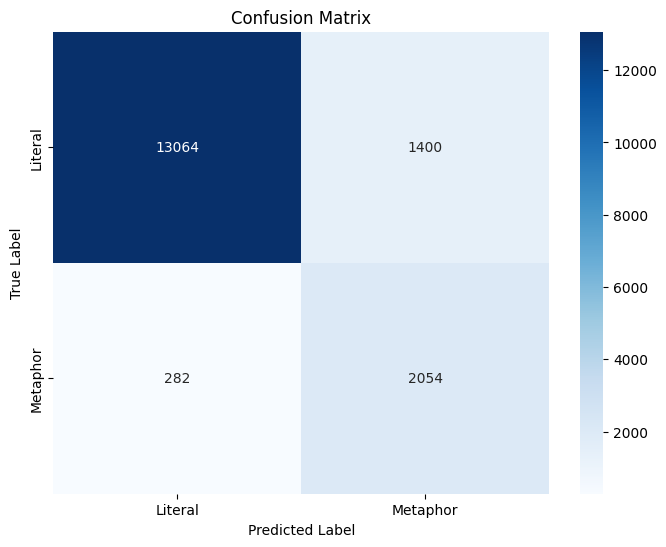

In [35]:
plot_confusion_matrix(
    results['preds'].label_ids[results['preds'].label_ids != -100].flatten(),
    results['preds'].predictions.argmax(-1)[results['preds'].label_ids != -100].flatten()
)

## F1 Score vs. Number of Metaphorical Samples by POS\


In [40]:
def plot_f1_vs_metaphor_samples(results, pos_categories=POS_CATEGORIES_TO_BALANCE):
    """Enhanced: dot size = total samples, label shows count"""

    preds = results['preds']
    y_true_clean = preds.label_ids[preds.label_ids != -100].flatten()
    y_pred_clean = preds.predictions.argmax(-1)[preds.label_ids != -100].flatten()

    # Align POS (your exact logic)
    test_ds = results['test_ds']
    mask = preds.label_ids != -100
    aligned_pos = []
    for i, mask_row in enumerate(mask):
        pos_tags = test_ds.simple_pos_list[i]
        aligned_pos.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

    # Calculate metrics per POS
    f1_scores = {}
    metaphor_counts = {}
    total_counts = {}

    for pos in pos_categories:
        pos_mask = np.array([p == pos for p in aligned_pos])
        if pos_mask.sum() == 0: continue

        y_pos_true = y_true_clean[pos_mask]
        y_pos_pred = y_pred_clean[pos_mask]

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_pos_true, y_pos_pred, average='binary', pos_label=1, zero_division=0
        )
        f1_scores[pos] = f1
        metaphor_counts[pos] = (y_pos_true == 1).sum()
        total_counts[pos] = len(y_pos_true)  # TOTAL samples for dot size

    # PLOT: size = total samples, label shows numbers
    plt.figure(figsize=(12, 8))

    # Dot sizes proportional to total samples (scale for visibility)
    sizes = np.array([total_counts[pos] * 0.1 for pos in total_counts])  # adjust multiplier

    scatter = plt.scatter(metaphor_counts.values(), f1_scores.values(),
                         s=sizes, alpha=0.7, c='coral', edgecolors='black', linewidth=1.5)

    # Annotate: POS + (metaphors/total)
    for pos in total_counts:
        plt.annotate(f'{pos}\n({metaphor_counts[pos]}/{total_counts[pos]})',
                    (metaphor_counts[pos], f1_scores[pos]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    plt.xlabel('Number of Metaphorical Samples', fontsize=12)
    plt.ylabel('Metaphor F1 Score', fontsize=12)
    plt.title('F1 Score vs. Metaphorical Samples by POS\n(Dot size ∝ total samples in POS)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print table
    print("\nPOS Analysis Table:")
    df_pos = pd.DataFrame({
        'POS': list(total_counts.keys()),
        'Total Samples': list(total_counts.values()),
        'Metaphor Samples': list(metaphor_counts.values()),
        'Metaphor %': [f"{m/t*100:.1f}%" for m,t in zip(metaphor_counts.values(), total_counts.values())],
        'F1 Metaphor': [f"{f1:.3f}" for f1 in f1_scores.values()]
    })
    print(df_pos.round(3).to_string(index=False))


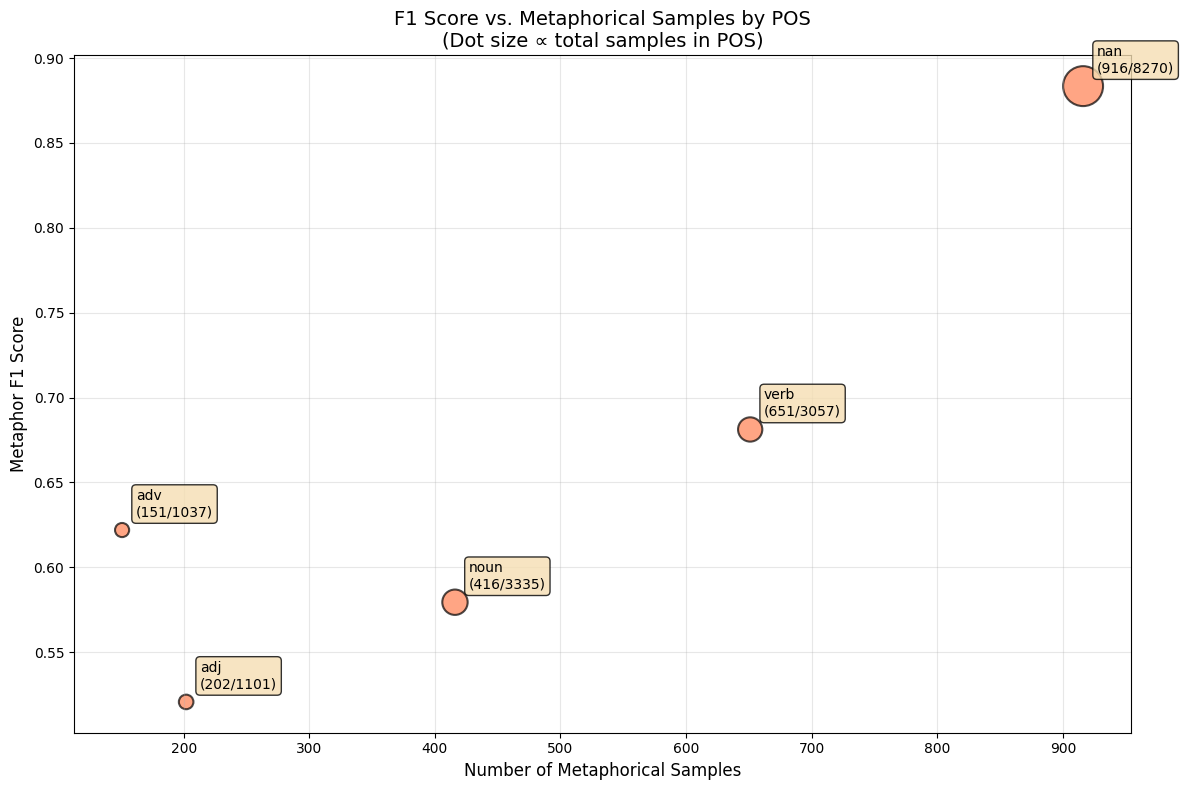


POS Analysis Table:
 POS  Total Samples  Metaphor Samples Metaphor % F1 Metaphor
noun           3335               416      12.5%       0.579
verb           3057               651      21.3%       0.681
 adj           1101               202      18.3%       0.521
 adv           1037               151      14.6%       0.622
 nan           8270               916      11.1%       0.884


In [41]:

plot_f1_vs_metaphor_samples(results)


## Metaphor Attention Diagnostic (?)
